# Object Detection

## Object Localization

- (1 object) Image classification is the task of just labeling the whole image with the correct label.

- (1 object) Classification with localization also aims to draw a bounding box for the label (e.g., the car).

- (multiple objects potentially of multiple types)Detection: Bounding box for multiple objects!



Pipeline for localization.

- In addition to have softmax for predicting the class, you have new layers that try to predict the bounding box coordinates as well
- so the model outputs for numbers:
    - bx: center horizontal
    - by: center vertical
    - bh: height
    - bw: width
    
**Defining the target label y**
<a id='target_label'></a>

Assume we have three classes:
1. pedestrian
2. car
3. motorcycle
4. background (none of the above class)
Correct label y will look like (assuming one object per image for now):

$$
\begin{bmatrix}
P_c\\
b_x\\
b_y\\
b_h\\
b_w\\
c1 \\
c2\\
c3
\end{bmatrix}
$$

where $P_c$ is 1 if there is any object, 0 o/w. and $c_x$ is 1 if the object belongs to class $x$, 0 o/w.


Case 1: Image contains a car.

$$
\begin{bmatrix}
1\\
b_x\\
b_y\\
b_h\\
b_w\\
0 \\
1\\
0
\end{bmatrix}
$$


Case 1: No object in the image.

$$
\begin{bmatrix}
0\\
?\\
?\\
?\\
?\\
? \\
?\\
?
\end{bmatrix}
$$ where $?$ denotes "dont care". We don't care about those indices and wont calculate loss on those!!

How do we calculate the loss?

Solution: sum over the squares of each index.

case 1. $y_1 = 1$

$$
L(\hat{y},y) = \sum_i^{8} (\hat{y}_i- y_i)^2
$$

case 2. $y_1 = 0$ (no object)

$$
L(\hat{y},y) = (\hat{y}_1- y_1)^2
$$

Final notes:

- Of course we can use negative log likelihood for class likelihoods (same as softmax).
- For $P_c$ we could use logistic regression loss
- For bounding box values we could use squared error or something similar.



## Landmark Detection

Instead of bounding box, predict x,y coordinates (point in the image) which is the landmark. We can have arbitrary number of landmarks in an image, for examples someone's face:

- around nose,
- around eyes,
- around mouth
- around face edge


To predict you can have a ConvNet that finally outputs 129 dimensions (assuming there are 64 landmarks in the image):

$$
\begin{bmatrix}
face?\\
l_{1x}\\
l_{1y}\\
.\\
.\\
l_{64x}\\
l_{64y}\\
\end{bmatrix}
$$

where $l_{1x} l_{1y}$ denote the position of the first landmark.

This is basic building block for:

- AR augmented reality filters in TikTok Instagram
- Emotion recognition from face.

Of course you need huge annotated dataset for this!! Someone will go annotate all those landmarks for all positions.

Same approach can also be used for pose estimation (see right image below)...

Important note: identity (index) of all landmarks should be consistent. Such as the first landmark should be left end of right eye etc. Sooo cumbersome lol.

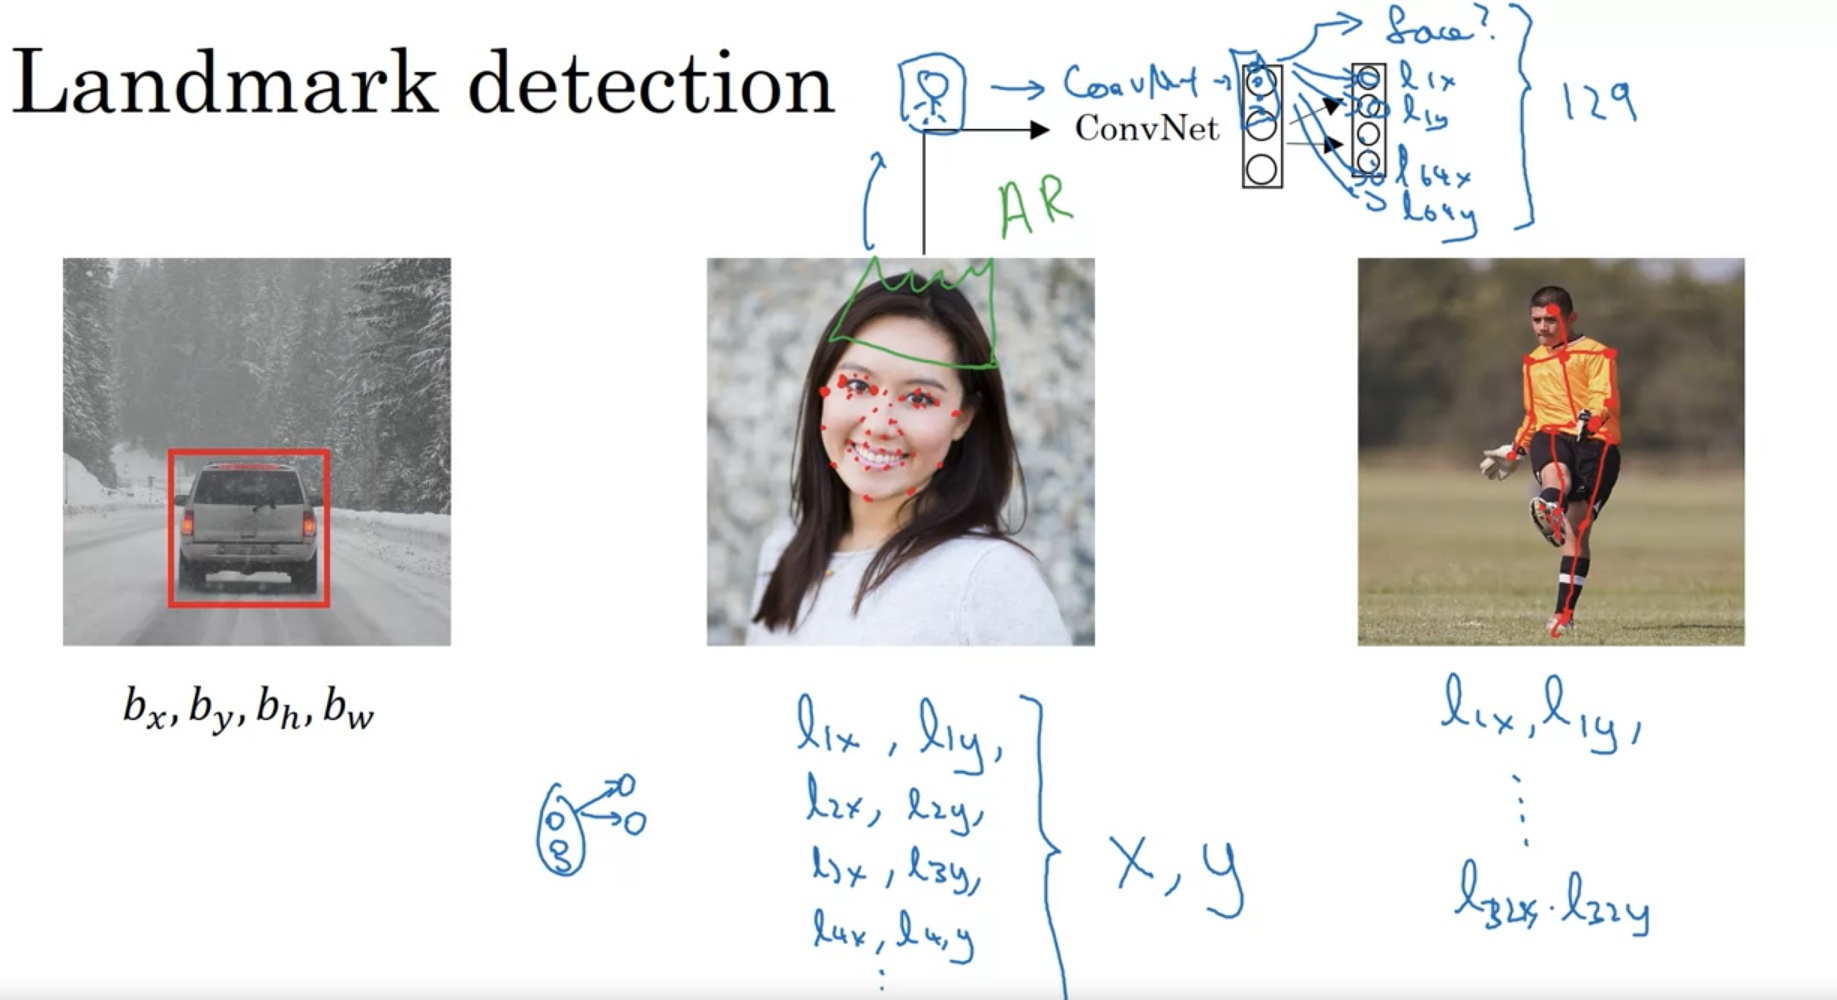

In [3]:
from IPython.display import Image
Image(filename='../../assets/landmarkdetection.jpg')

## Object Detection

Lets build up object detection algo using what we learned.


One approach: Sliding Windows Detection


- First we build a training dataset where we only have objects tightly extracted from each image (cropped from the full images). So our training dataset contains images where it is only car (if car exists) and again small background image for negative samples (car doesn't exist). 

- Then during the prediction time, we apply sliding window approach on the image in increasingly larger window sizes. We hope that in some window, a car was fully included or at least mostly so our algorithm can detect it. This way we can predict multiple cars if they appear in different windows in our sliding window approach.

Let's say started with 16x16 window slide over the whole image. Then increase the window to 32 and repeat etc.

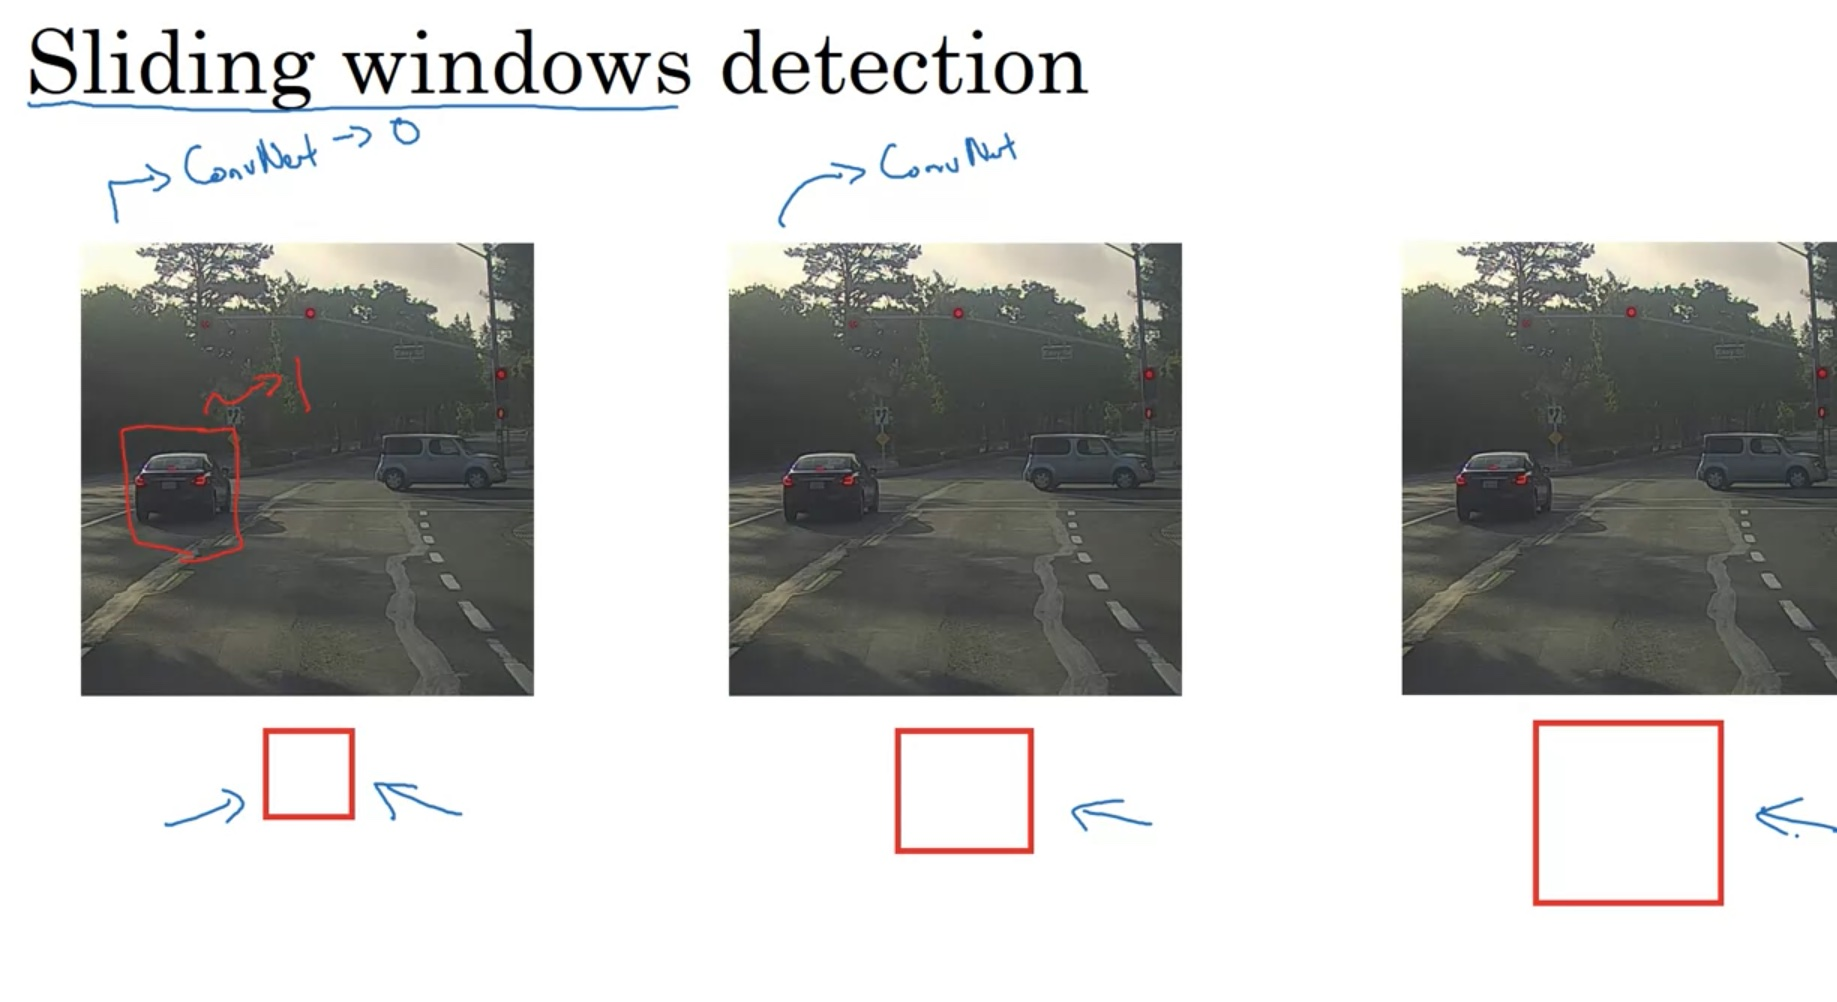

In [4]:
Image(filename='../../assets/objectdetection_slidingwindow.jpg')

**Huge Disadvantage** Computational Cost

- You are cropping soo many images and repeat
- If you increase the stride size, you might risk skip an object...


In old days, object detectors were super hand-engineered and cheap/fast to run many times. However in DNN era, it is computationally expensive to run these larger models hundreds of times.

## Convolutional Implementation of Sliding Windows

First we should turn FC layer into convolutional layers!!

- Instead of having good old FC layers at the end, lets define them as many number of (equal to the FC hidden units) 1x1 convolutions. 
- Best explained by the visual below.
- Remember that our goal is to predict four classes so softmax is of size 4 and the convolution output has four channels.

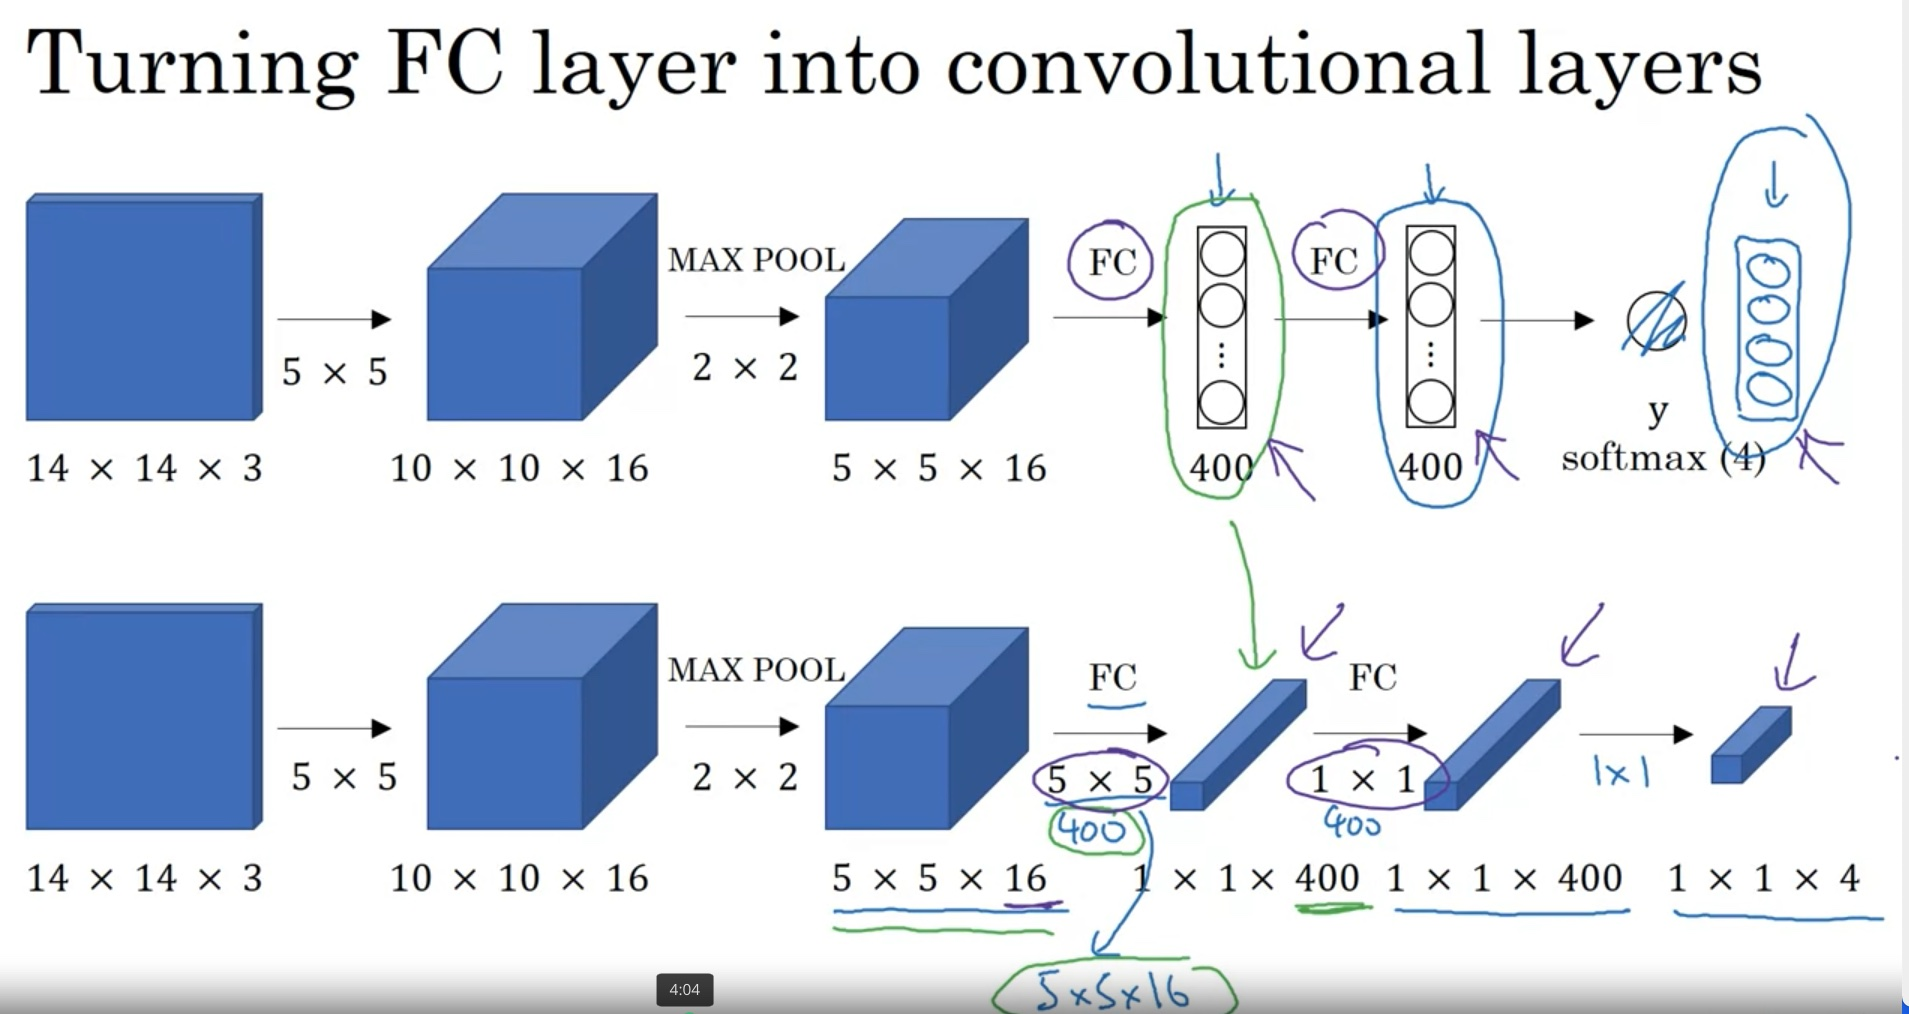

In [7]:
Image(filename='../../assets/fc_as_1d_convolution.jpg')

- Then imagine that we keep the architecture the same and pad unidirectionally by 2 (for illustration purposes). 
- Keeping everything the same, this would yield at the end a volume of 2x2x4. This is equivalent to having 4 sliding windows (2x2=4) with stride one calculated over the 16x16 image!!
- This is amazing because we avoided doing a looooot of duplicate calculation (that would be the case with sliding window approach) by formulating the sliding window as convolution operation , yay!


Rule of thumb to think about it is that we have max pooling 2x2 so it translates to having 2x2 (with stride=2) so that corresponds to having slidin windows with stride=2 in the original input.

So the output of the below 8x8x4 is literally making 64 predictions about 4 classes in one go, Amazing!!

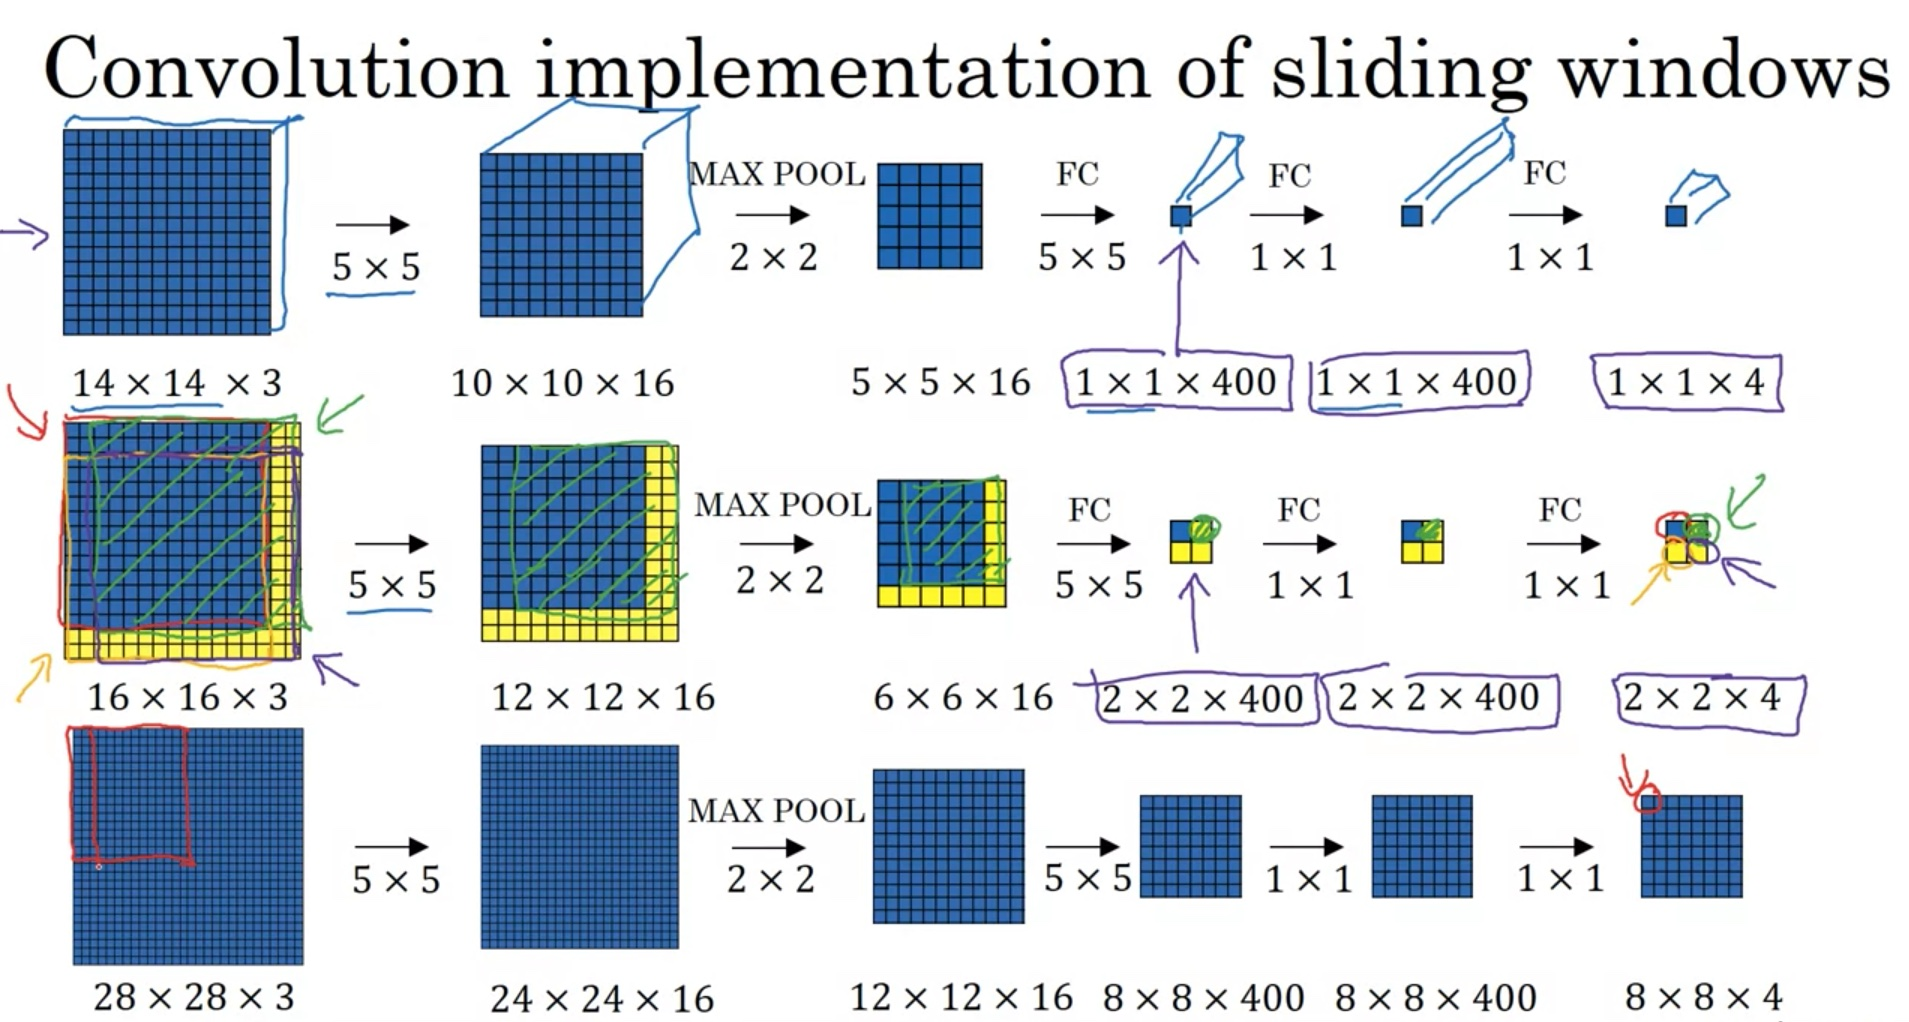

In [11]:
Image(filename='../../assets/fc_as_1d_conv_example.jpg')

## Bounding Box Predictions

One problem with the above approach is that what if the sliding windows are not that accurate?  

Let's see how we can find the boxes more accurately.

- The car could be half included in one window and half included in another.
- Ground truth also doesn't have to be a square!! 


Solution: YOLO algorithm (You Only Look Once) https://arxiv.org/abs/1506.02640

- Divide the input image to a grid (19x19 for example).
- For each grid cell have an input Y vector as described in [here](#target_label)
- If two grids include the same object it is fine. We use the center point of the object $(b_x,b_y)$ to decided which grid cell an image belongs to.
- If the grid is 3x3 our target output will have shape 3x3x8.
- Now the input is still the same (100x100x3)
- You should arrange your network such that it should output 3x3x8 as well!!
- Great advantage here is that the algorithm will output the precise bounding boxes!! So we resolved the issue of inaccurate sliding windows of the previous solution.


One potential concern: What if there are multiple objects in the same grid?? In practice we use much finer grid (19x19) so the chances that multiple objects have their center in the same grid cell is fairly low.

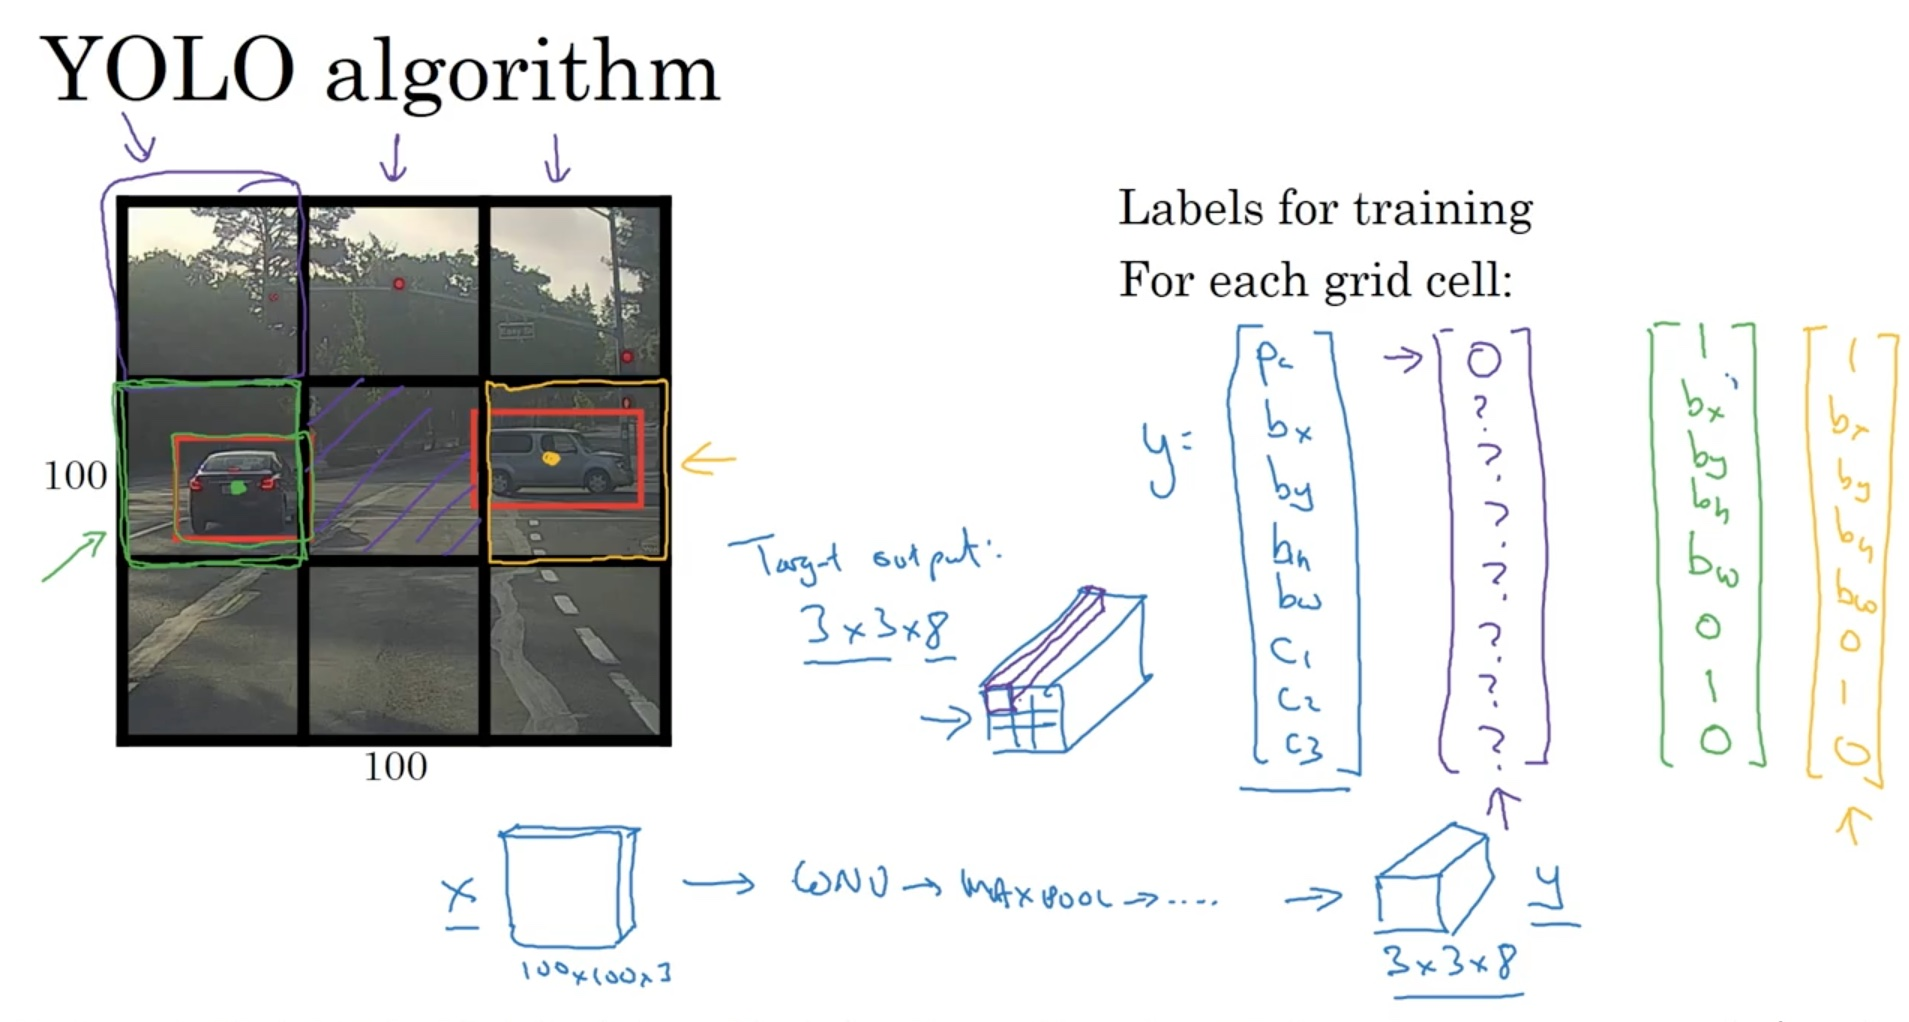

In [13]:
Image(filename='../../assets/yolo.jpg')

**How to Specify the bounding boxes**

- Each grid cell is considered to be of size 1 by 1 square (from (0,0) to (1,1)).
- Upper left is the (0,0) point.
- By definition $(b_x,b_y)$ (the center of the object must be within the grid cell).
- But it is fine to have $b_h$ and $b_w$ have values that potentially get out of bounds of the grid. Example center is (0.5,0.5) and $b_w=0.9$. This is fine
- Of course all values must be non-negative since these denote real sizes!

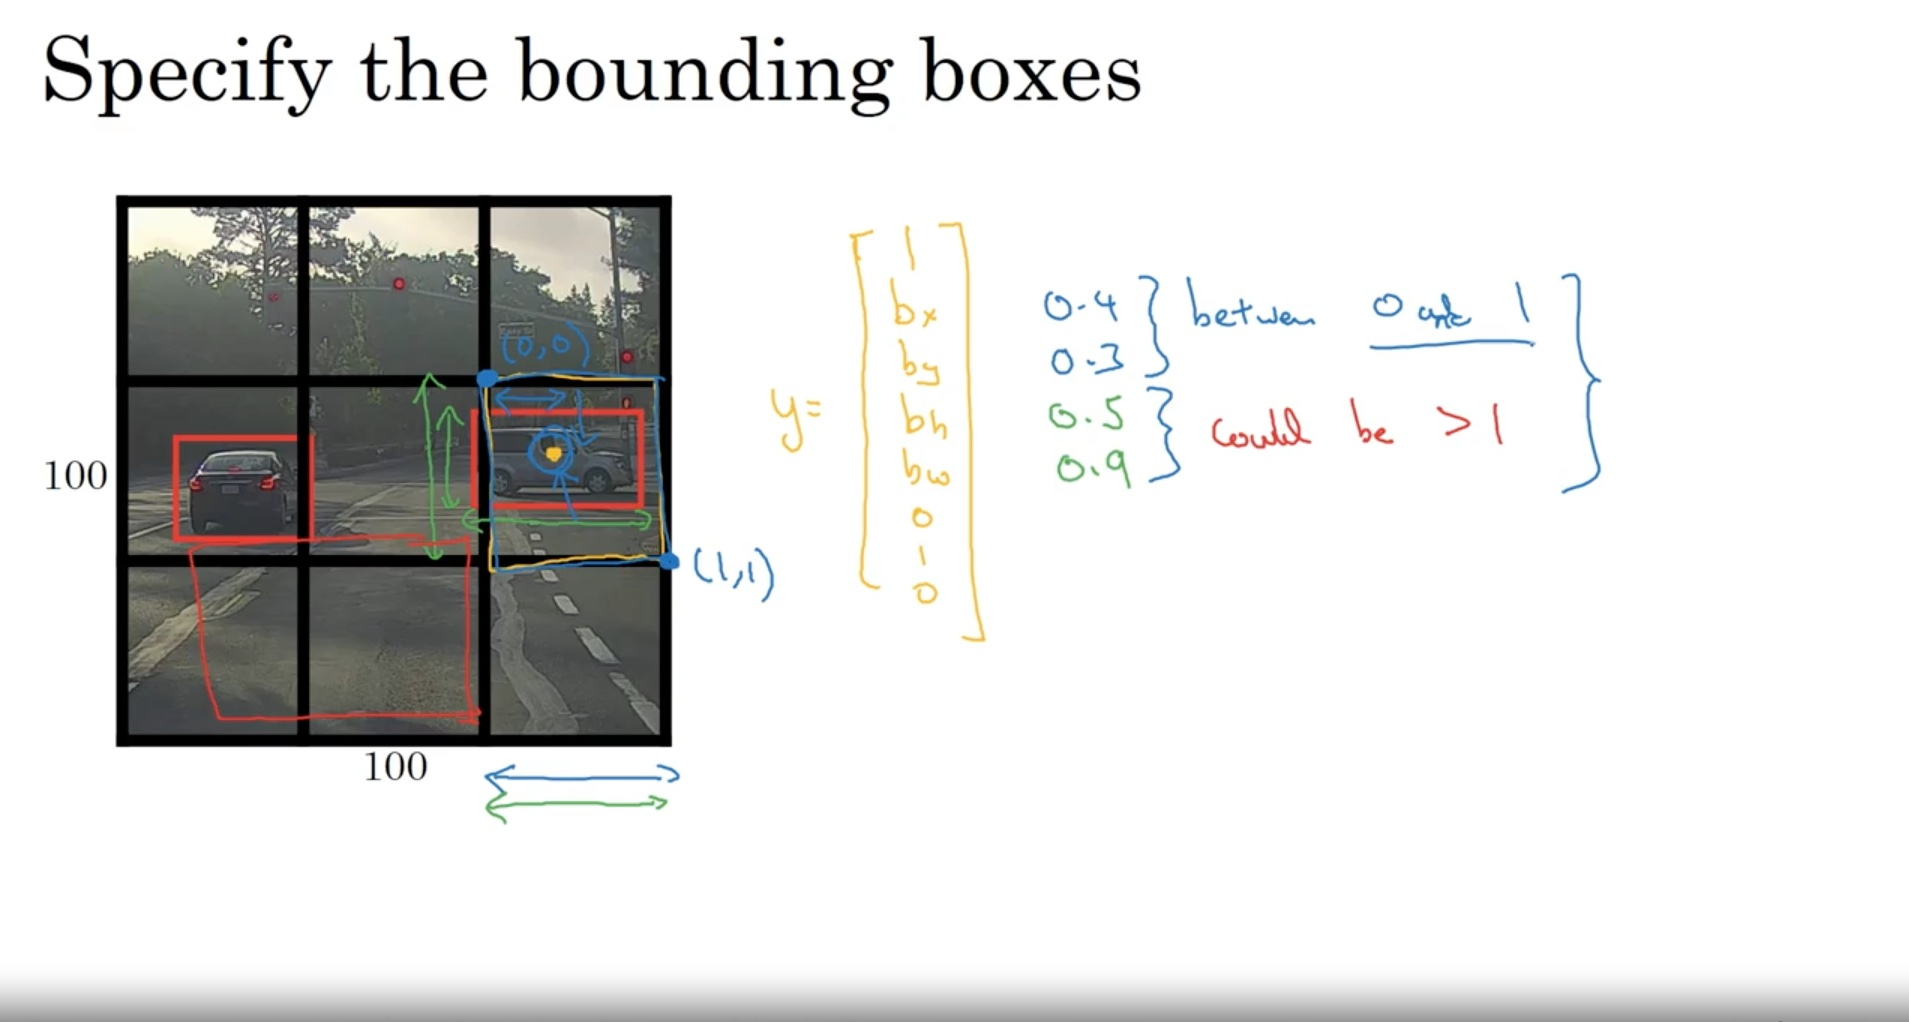

In [14]:
Image(filename='../../assets/bounding_box_specification.jpg')

## Intersection over Union

How do you tell if your algorithm is working well? 


- Compute Intersection over Union of the predicted and the correct bounding boxes
- Correct if IoU is greater than 0.5 (common convention is to use 0.5)
- Perfect score is 1.0  

## Non-max Suppression

One problem is your algorithm might find multiple objects for one single object. Example is maybe for 3-4 grid (neighboring) cells, it will predict there is a separate car..

Non-max suppression help us avoid this. Here is simple algorithm:

- Discard all boxes with $p_c<0.6$
- Combine all overlapping bounding-box predictions (high IoU) into one single prediction. 
- For each group rank the bounding box in the descending order of their probability (likelihood of having a car).
- Finally commit to the bounding box with the highest probability and discard the other predictions. 


Algorithm Andrew explained:

- Discard all boxes with $p_c\leq0.6$ (weak guesses)
- Rank your prediction boxes in descending order of p values. Pick the top one.
- Discard all other boxes that had $IoU\geq0.5$ with any over the previously picked boxes.
- Repeat step 2 and 3 until we don't have any boxes left.


If you have 3 classes of objects (not just cars), it is good idea to repeat the above algorithm separately for all classes (this could be done in parallel too).

## Anchor Boxes

What if we want to detect multiple objects in the same grid cell?

Idea: Use multiple anchor boxes for each grid cell. 

- Let's say you have a pre-defined two anchor boxes for each grid cell. For example, one anchor box that is thin and tall (human standing), and the other is short and wide (car).
- We decide which object belongs to which anchor box by using IoU between anchor box and the object's bounding box and pick the best one. So each object belong to a tuple like (grid cell, anchor box).
- Then your target output label will now be concatenation of Ys for each anchor box for a given grid cell. So if Y used to be 8 dim, with two anchor boxes it will be of size 16.
- And now during prediction, if our algorithm thinks, car belongs to second anchor box it will used the bottom 8 dimension of its output for the prediction.


My overall feeling of all these methods is that they are just hacks and hacks to improve performance. It just feels like a lot of hand engineering trial/error stuff.. I could also think of these by myself in a given CV project.

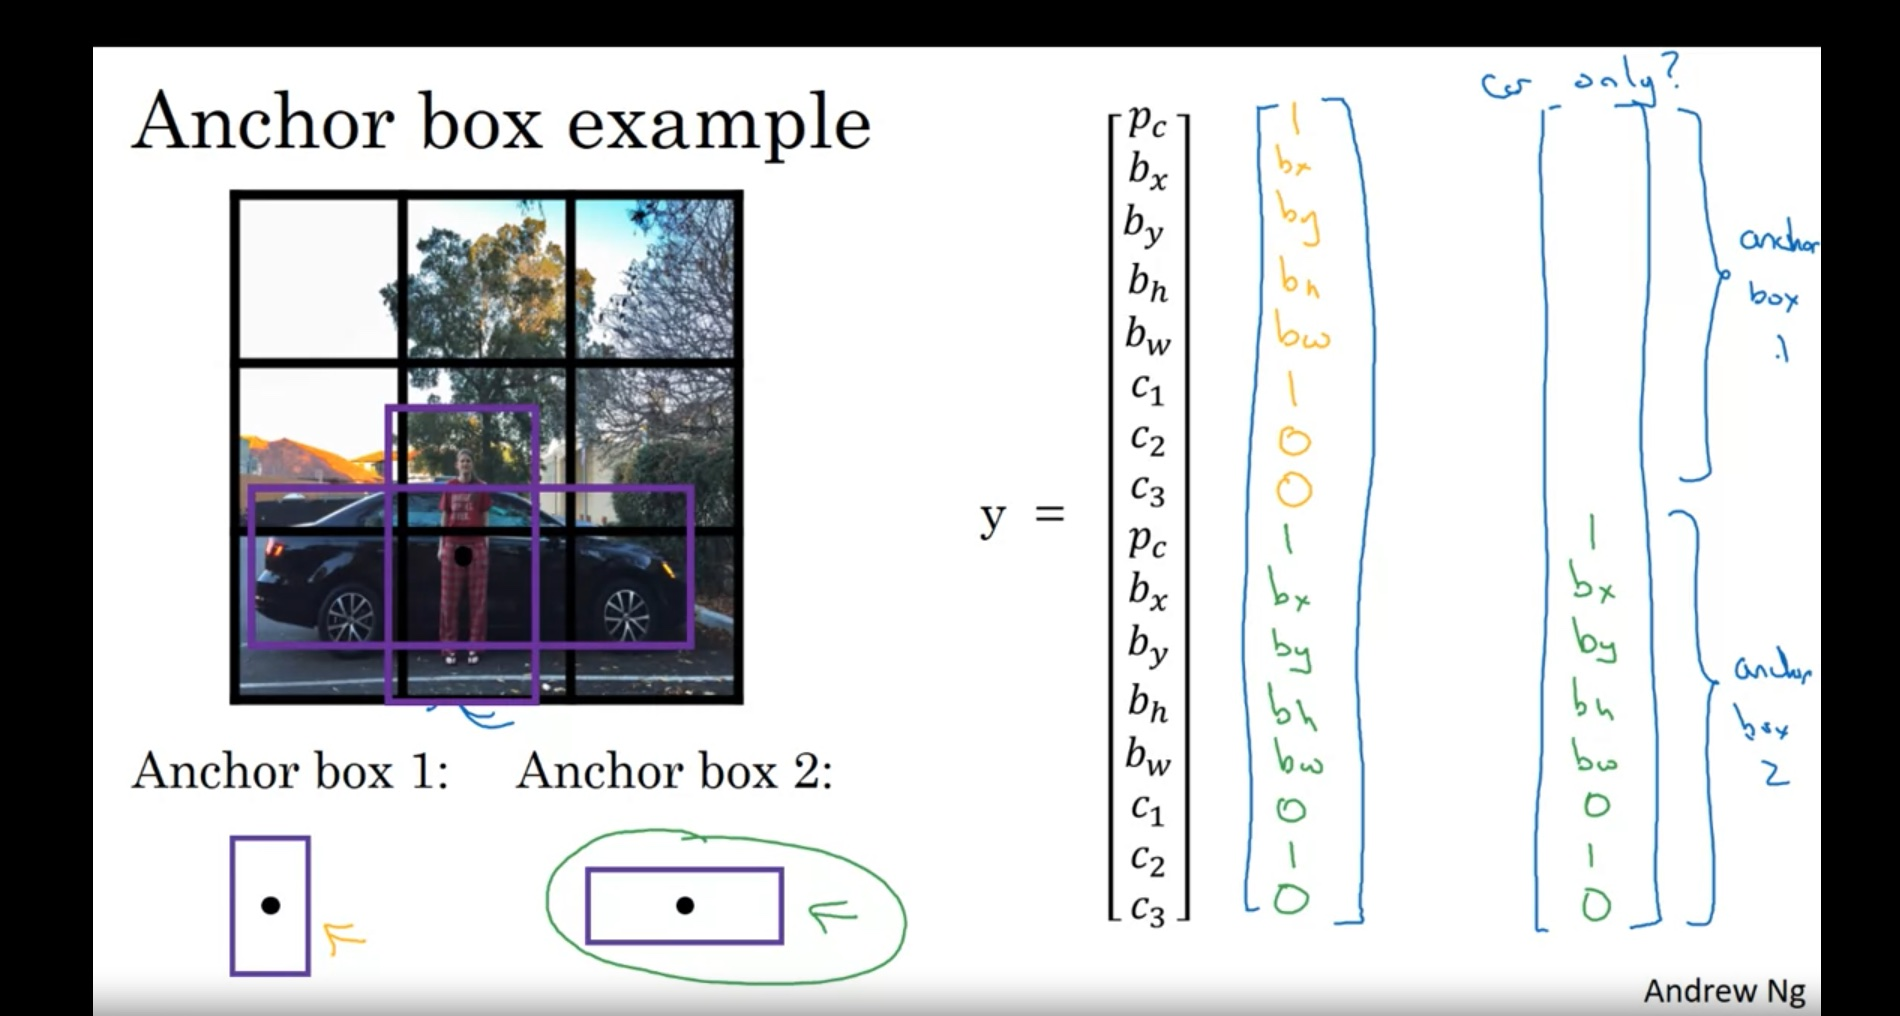

In [17]:
Image(filename='../../assets/anchorboxexample.jpg') 



Important notes:
- The algorithm doesn't really have a way of dealing with the edge cases when multiple objects in the same grid cell are of same type of anchor box.

- Again note that multiple objects rarely have their centers inside the same grid cells.

- More than handling the above edge cases of having multiple objects, actually what Anchor boxes help achieve is that the neural network become more expert at detecting objects of different shape features. Some neurons might become thin and tall object detectors and some can become short and wide object detectors!

- Sometimes we manually define 5-10 anchor boxes ourselves. More advanced option is to use something like kMeans clustering on the training set bounding boxes and find the most commonly occurring bounding box shape types and use them as anchor box options.

## YOLO Algorithm

Combine everything together in the video.


**Creating the labels**

- Divide input image into 3x3 grid cells.
- And for each grid cell, lets assume we have 2 anchor boxes possible.
- For each grid cell, find all objects that occur in them.
- Determine which anchor box each object belongs to by using max value of IoU with their bounding box.
- Construct the 3x3x16 (2x8) target label. Recall that 8 is coming from 1 (is there any object?) + 4 (bounding box) + 3 (#num class we had: pedestrian, car and motorcycle).
- In real life, we might have 19x19 grid cell with 5 anchor boxes which would result in 19x19x40 target label.

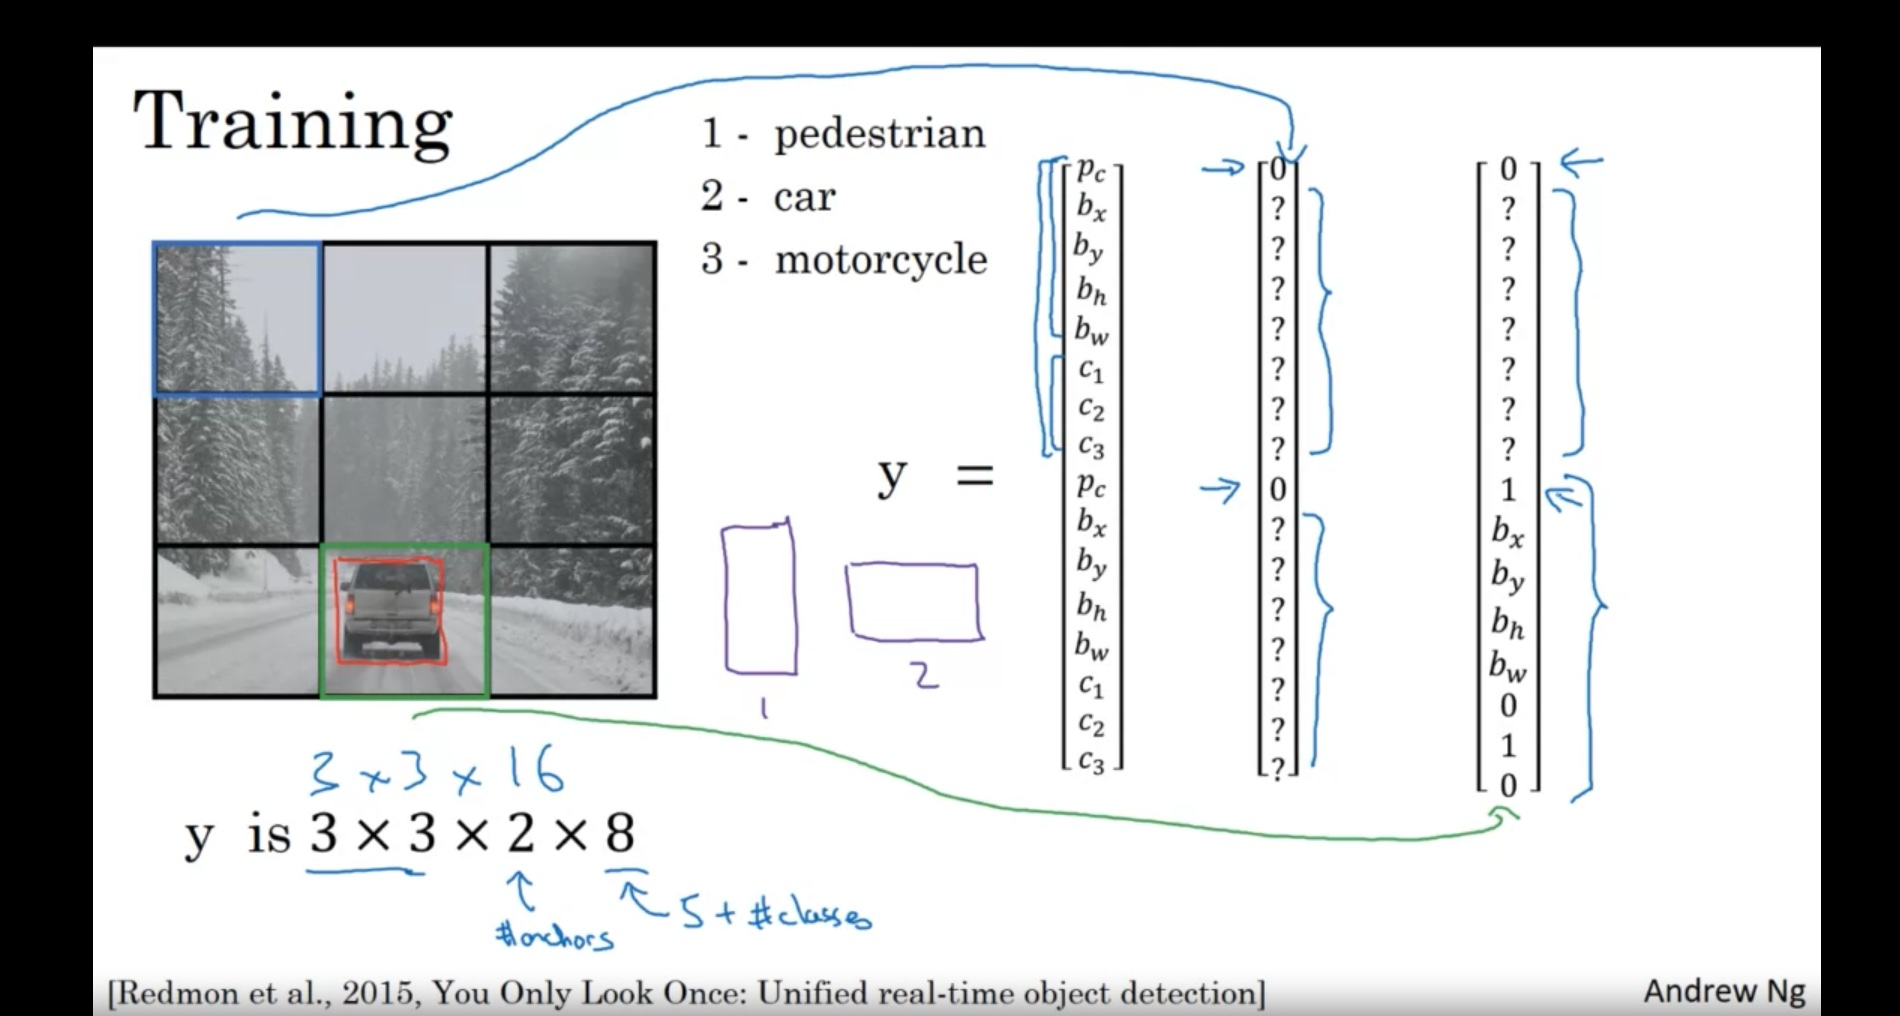

In [20]:
Image(filename='../../assets/yolo_create_target.jpg') 

**Making Predictions**

- You should setup your ConvNet such that it outputs 3x3x16 volume.
- First apply non-max suppression step: 
    - Discard all low probability predictions, for each class rank the predictions by highest probability and merge them if they have more than 0.5 IoU with other predictions. 
    - Finally you will get rid of all overlapping predictions and get the final predictions you have. 
    - Remember that the anchor boxes can overflow the grid cell they belong to. That's not a problem. Their size is declared still the same way using the $b_x, b_y, b_h, b_w$

## Region Proposals (Optional)

Idea is that instead of having an inefficient sliding window approach, lets try to be more about finding regions likely to contain an object.

- Use a segmentation algorithm to segment the image. Use this to propose a few regions to run the object detection model. Run classifier on each blob found by the segmentation model.

- This is also useful in the sense that the shapes dont have to be square. It can be any shape.


R-CNN is actually quite slow. 

Fast R-CNN. 

- Propose regions.
- Use Convolution implementation of sliding windows to classify all the proposed regions at one go.

Turns out Fast R-CNN is still slow because region proposal step is slow...


Faster R-CNN.

- Use convolution to propose the regions.

## Semantic Segmentation with U-Net

Instead of bounding box, exactly denote which pixels constitute an object. So every single pixel of the image is labeled by the model.

- Every pixel has a label.
- If we only care about car vs non-car. We have have 0 to denote all pixels without car and 1 for all pixels with car. If you have more classes simply enumerate as 2-3...


Motivation for U-Net.

- In typical ConvNet, the feature map size (height width) shrinks as the number of channels increase.
- However, for image segmentation, we need to output a 2D matrix that has the same shape as the input image since we need one prediction for each pixel.
- For that we need a new operation that increases the feature map size, because even with 1x1 convolution, we could at best keep the size same.. 
- Next video defines something called Transpose Convolutions

## Transpose Convolutions

How do you get 2x2 input and blow it up to 4x4 ?? 


- Input 2x2 we want to end up with 4x4
- We use a filter of size 3x3 
- padding=1 and stride=2 (these are on the output not the filter or input)


Instead of convolving the filter over the input we do the opposite.

- Take each element of the input and multiply the whole filter with it.
- Then place the multiplied filter on the appropriate place in the padded output (4x4 with padding so it is 6x6) starting from top left. 
- Whenever there is an intersection, we add the elements. 


Best explained with an example image. https://d2l.ai/chapter_computer-vision/transposed-conv.html#basic-operation 

## U-Net Architecture Intuition

- First part is normal convolutions. It compresses the image and makes it deeper!
- Second part does the opposite: Shrink the depth and increase the image size.
- Turns out that skip connections are vital to improve the performance.
    - We need high-level spatial info
    - We also need low-level fine grained spatial info like basic texture.
    - Combining these two allows us to do semantic segmentation yay!!
    - Skip Connections enable us to achieve this!!

## U-Net Architecture

Lets break it down..

Initially proposed for Biomedical Image Segmentation!! I knoow https://link.springer.com/content/pdf/10.1186/s12859-020-3459-0.pdf 


- We start by applying normal convolution and max pooling
- Which reduce the height and width while increasing the depth.
- Then at some point, we start transpose convolutions with skip connections:
    - apply transpose convolution which increase h and w while shrinking the depth. 
    - then we add the corresponding normal convolution layer's output as skip connection (concatenate the two volumes)
    - We keep doing that until we reach the original image height and width.
    
- Finally, we have some normal convolution with Relu
- Lastly, we have a 1x1 convolution with $n_c$ channels to reduce the shape to $hxwxn_c$

where $n_c$ is the number of classes we are predicting. It is like softmax output for each pixel.
